# Income

## Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from census import Census 
from us import states 
import contextily as ctx

In [2]:
from Globals import CENSUS_KEY

In [3]:
# Set API key
c = Census(CENSUS_KEY)

## Variables

In [33]:
# Grabbing a few variables of interest pertaining to the economic vitality of an area
fields = {
    "NAME" : "Name"
    , "B19001_001E" : "Total Households"
    , "B19001_002E" : "HH Less than $10,000"
    , "B19001_003E" : "HH $10,000 to $14,999"
    , "B19001_004E" : "HH $15,000 to $19,999"
    , "B19001_005E" : "HH $20,000 to $24,999"
    , "B19001_006E" : "HH $25,000 to $29,999"
    , "B19001_007E" : "HH $30,000 to $34,999"
    , "B19001_008E" : "HH $35,000 to $39,999"
    , "B19001_009E" : "HH $40,000 to $44,999"
    , "B19001_010E" : "HH $45,000 to $49,999"
    , "B19001_011E" : "HH $50,000 to $59,999"
    , "B19001_012E" : "HH $60,000 to $74,999"
    , "B19001_013E" : "HH $75,000 to $99,999"
    , "B19001_014E" : "HH $100,000 to $124,999"
    , "B19001_015E" : "HH $125,000 to $149,999"
    , "B19001_016E" : "HH $150,000 to $199,999"
    , "B19001_016E" : "HH $200,000 or more"
    , "B19083_001E" : "Gini Index"
    , "B19301_001E" : "Per capita income"
    , "B19301A_001E" : "PC income White"
    , "B19301B_001E" : "PC income Black African American"
    , "B19301C_001E" : "PC income American Indian Alaska Native"
    , "B19301D_001E" : "PC income Asian"
    , "B19301E_001E" : "PC income Native Hawaiian Pacific Islander"
    , "B19301F_001E" : "PC income Other"
    , "B19301G_001E" : "PC income Two or More Races"
    , "B19301I_001E" : "PC income Hispanic or Latino"
}

## Download three years

In [34]:
def nm_dl(year):
    data = c.acs5.state_county_tract(
        fields = list(fields.keys()),
        state_fips = states.NM.fips,
        county_fips = "*",
        tract = "*",
        year = year
        )
    return data

In [35]:
nm_demo_2022_df = pd.DataFrame(nm_dl(2022))
nm_demo_2019_df = pd.DataFrame(nm_dl(2019))
nm_demo_2016_df = pd.DataFrame(nm_dl(2016))

In [36]:
for df in [nm_demo_2022_df, nm_demo_2019_df, nm_demo_2016_df]: 
    df.rename(columns=fields, inplace=True)

## Download geometries and merge

In [37]:
nm_tract_2022 = gpd.read_file('../../../localData/Census/nm_tract_2022.gpkg').to_crs(epsg = 32113)[['GEOID', 'geometry']]
nm_tract_2019 = gpd.read_file('../../../localData/Census/nm_tract_2019.gpkg').to_crs(epsg = 32113)[['GEOID', 'geometry']]
nm_tract_2016 = gpd.read_file('../../../localData/Census/nm_tract_2016.gpkg').to_crs(epsg = 32113)[['GEOID', 'geometry']]

In [38]:
for df in [nm_demo_2016_df, nm_demo_2019_df, nm_demo_2022_df]: 
    df['GEOID'] = (df.state + df.county + df.tract)

In [168]:
nm_demo_2022 = nm_tract_2022.merge(nm_demo_2022_df, on='GEOID')
nm_demo_2019 = nm_tract_2019.merge(nm_demo_2019_df, on='GEOID')
nm_demo_2016 = nm_tract_2016.merge(nm_demo_2016_df, on='GEOID')

In [169]:
nm_demo_2022.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 32 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   GEOID                                       612 non-null    object  
 1   geometry                                    612 non-null    geometry
 2   Name                                        612 non-null    object  
 3   Total Households                            612 non-null    float64 
 4   HH Less than $10,000                        612 non-null    float64 
 5   HH $10,000 to $14,999                       612 non-null    float64 
 6   HH $15,000 to $19,999                       612 non-null    float64 
 7   HH $20,000 to $24,999                       612 non-null    float64 
 8   HH $25,000 to $29,999                       612 non-null    float64 
 9   HH $30,000 to $34,999                       612 non-null    float64 

In [170]:
HH_LT20 = ['HH Less than $10,000', 'HH $10,000 to $14,999', 
          'HH $15,000 to $19,999']
HH_20_40 = ['HH $20,000 to $24,999', 'HH $25,000 to $29,999', 
           'HH $30,000 to $34,999', 'HH $35,000 to $39,999']
HH_40_60 = ['HH $40,000 to $44,999', 'HH $45,000 to $49,999', 
           'HH $50,000 to $59,999']
HH_60_100 = ['HH $60,000 to $74,999', 'HH $75,000 to $99,999']
PC_Other = ['PC income Other', 'PC income Two or More Races']
PC_Native = ['PC income American Indian Alaska Native', 'PC income Native Hawaiian Pacific Islander']

In [171]:
dfs = [nm_demo_2022, nm_demo_2019, nm_demo_2016]

In [172]:
for df in dfs:
    df['HH Less than $20,000'] = df.loc[:, HH_LT20].sum(axis=1)
    df['HH $20,000 to $39,000'] = df.loc[:, HH_20_40].sum(axis=1)
    df['HH $40,000 to $59,000'] = df.loc[:, HH_40_60].sum(axis=1)
    df['HH $60,000 to $99,000'] = df.loc[:, HH_60_100].sum(axis=1)
    df['PC income Other Mixed'] = df.loc[:, PC_Other].sum(axis=1)
    df['PC income Native'] = df.loc[:, PC_Native].sum(axis=1)
    df.drop(columns=
            HH_LT20 + HH_20_40 + HH_40_60 + HH_60_100 + PC_Other + PC_Native,
            inplace=True)
    df['area skm'] = df.area / 1e6

In [173]:
nm_demo_2022.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   GEOID                             612 non-null    object  
 1   geometry                          612 non-null    geometry
 2   Name                              612 non-null    object  
 3   Total Households                  612 non-null    float64 
 4   HH $100,000 to $124,999           612 non-null    float64 
 5   HH $125,000 to $149,999           612 non-null    float64 
 6   HH $200,000 or more               612 non-null    float64 
 7   Gini Index                        612 non-null    float64 
 8   Per capita income                 609 non-null    float64 
 9   PC income White                   603 non-null    float64 
 10  PC income Black African American  444 non-null    float64 
 11  PC income Asian                   431 non-null    

In [174]:
nm_demo_2022 = nm_demo_2022[nm_demo_2022['Total Households'] > 0]
nm_demo_2019 = nm_demo_2019[nm_demo_2019['Total Households'] > 0]
nm_demo_2016 = nm_demo_2016[nm_demo_2016['Total Households'] > 0]

In [175]:
nm_demo_2022 = nm_demo_2022[nm_demo_2022['Gini Index'] > 0]
nm_demo_2019 = nm_demo_2019[nm_demo_2019['Gini Index'] > 0]
nm_demo_2016 = nm_demo_2016[nm_demo_2016['Gini Index'] > 0]

In [176]:
nm_demo_2022.describe()

,Total Households,"HH $100,000 to $124,999","HH $125,000 to $149,999","HH $200,000 or more",Gini Index,Per capita income,PC income White,PC income Black African American,PC income Asian,PC income Hispanic or Latino,"HH Less than $20,000","HH $20,000 to $39,000","HH $40,000 to $59,000","HH $60,000 to $99,000",PC income Other Mixed,PC income Native,area skm
count,599.000000,599.000000,599.000000,599.000000,599.000000,598.000000,5.910000e+02,4.310000e+02,4.180000e+02,5.890000e+02,599.000000,599.000000,599.000000,599.000000,5.990000e+02,5.990000e+02,599.000000
mean,1356.969950,114.704508,83.357262,89.414023,0.434802,32787.643813,-7.859758e+06,-2.830427e+08,-3.572361e+08,-7.896042e+06,232.677796,247.686144,211.343907,294.948247,-5.448193e+07,-7.178477e+08,522.414355
std,607.430447,95.733279,79.009795,98.133887,0.067459,15437.937525,7.218858e+07,3.299209e+08,3.328944e+08,7.230873e+07,164.910834,148.224954,134.654501,185.282336,2.231459e+08,3.137769e+08,1527.173205
min,11.000000,0.000000,0.000000,0.000000,0.051200,5748.000000,-6.666667e+08,-6.666667e+08,-6.666667e+08,-6.666667e+08,0.000000,0.000000,0.000000,0.000000,-1.333333e+09,-1.333333e+09,0.647684
25%,913.500000,47.000000,26.000000,21.000000,0.392300,22368.500000,2.491800e+04,-6.666667e+08,-6.666667e+08,1.895500e+04,118.000000,137.500000,116.000000,166.500000,3.381350e+04,-6.666667e+08,2.692058
50%,1274.000000,91.000000,61.000000,60.000000,0.429300,28998.500000,3.243300e+04,1.180400e+04,-6.666667e+08,2.410800e+04,194.000000,222.000000,182.000000,260.000000,4.741400e+04,-6.666543e+08,10.020778
75%,1747.500000,160.000000,116.000000,119.500000,0.479700,38846.500000,4.430750e+04,3.058500e+04,3.456900e+04,3.231900e+04,314.000000,324.500000,281.000000,378.500000,6.604350e+04,-6.666383e+08,121.103736
max,4189.000000,681.000000,483.000000,663.000000,0.721000,112485.000000,1.182540e+05,3.006010e+05,2.548070e+05,1.416470e+05,1037.000000,824.000000,1040.000000,1409.000000,2.915600e+05,5.737300e+04,12842.681841


In [177]:
HHCols = ([c for c in list(nm_demo_2022.columns) if c.startswith('HH')]
          + ['Total Households'])
PCCols = ([c for c in list(nm_demo_2022.columns) if c.startswith('PC')]
          + ['Per capita income'])

In [178]:
nm_hh_inc_2022 = nm_demo_2022.copy().drop(columns=PCCols)
nm_hh_inc_2019 = nm_demo_2022.copy().drop(columns=PCCols)
nm_hh_inc_2016 = nm_demo_2022.copy().drop(columns=PCCols)
nm_pc_inc_2022 = nm_demo_2022.copy().drop(columns=HHCols)
nm_pc_inc_2019 = nm_demo_2022.copy().drop(columns=HHCols)
nm_pc_inc_2016 = nm_demo_2022.copy().drop(columns=HHCols)

In [179]:
nm_hh_inc_2022.describe()

,Total Households,"HH $100,000 to $124,999","HH $125,000 to $149,999","HH $200,000 or more",Gini Index,"HH Less than $20,000","HH $20,000 to $39,000","HH $40,000 to $59,000","HH $60,000 to $99,000",area skm
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,1356.969950,114.704508,83.357262,89.414023,0.434802,232.677796,247.686144,211.343907,294.948247,522.414355
std,607.430447,95.733279,79.009795,98.133887,0.067459,164.910834,148.224954,134.654501,185.282336,1527.173205
min,11.000000,0.000000,0.000000,0.000000,0.051200,0.000000,0.000000,0.000000,0.000000,0.647684
25%,913.500000,47.000000,26.000000,21.000000,0.392300,118.000000,137.500000,116.000000,166.500000,2.692058
50%,1274.000000,91.000000,61.000000,60.000000,0.429300,194.000000,222.000000,182.000000,260.000000,10.020778
75%,1747.500000,160.000000,116.000000,119.500000,0.479700,314.000000,324.500000,281.000000,378.500000,121.103736
max,4189.000000,681.000000,483.000000,663.000000,0.721000,1037.000000,824.000000,1040.000000,1409.000000,12842.681841


In [180]:
nm_pc_inc_2022.describe()

,Gini Index,Per capita income,PC income White,PC income Black African American,PC income Asian,PC income Hispanic or Latino,PC income Other Mixed,PC income Native,area skm
count,599.000000,598.000000,5.910000e+02,4.310000e+02,4.180000e+02,5.890000e+02,5.990000e+02,5.990000e+02,599.000000
mean,0.434802,32787.643813,-7.859758e+06,-2.830427e+08,-3.572361e+08,-7.896042e+06,-5.448193e+07,-7.178477e+08,522.414355
std,0.067459,15437.937525,7.218858e+07,3.299209e+08,3.328944e+08,7.230873e+07,2.231459e+08,3.137769e+08,1527.173205
min,0.051200,5748.000000,-6.666667e+08,-6.666667e+08,-6.666667e+08,-6.666667e+08,-1.333333e+09,-1.333333e+09,0.647684
25%,0.392300,22368.500000,2.491800e+04,-6.666667e+08,-6.666667e+08,1.895500e+04,3.381350e+04,-6.666667e+08,2.692058
50%,0.429300,28998.500000,3.243300e+04,1.180400e+04,-6.666667e+08,2.410800e+04,4.741400e+04,-6.666543e+08,10.020778
75%,0.479700,38846.500000,4.430750e+04,3.058500e+04,3.456900e+04,3.231900e+04,6.604350e+04,-6.666383e+08,121.103736
max,0.721000,112485.000000,1.182540e+05,3.006010e+05,2.548070e+05,1.416470e+05,2.915600e+05,5.737300e+04,12842.681841


In [181]:
PCCols[:-1]

['PC income White',
 'PC income Black African American',
 'PC income Asian',
 'PC income Hispanic or Latino',
 'PC income Other Mixed',
 'PC income Native']

In [182]:
import numpy as np 

In [183]:
for column in PCCols[:-1]:
    nm_pc_inc_2022.loc[nm_pc_inc_2022[column] < 0, column] = np.nan
    nm_pc_inc_2019.loc[nm_pc_inc_2019[column] < 0, column] = np.nan
    nm_pc_inc_2016.loc[nm_pc_inc_2016[column] < 0, column] = np.nan

In [184]:
nm_pc_inc_2019.describe()

,Gini Index,Per capita income,PC income White,PC income Black African American,PC income Asian,PC income Hispanic or Latino,PC income Other Mixed,PC income Native,area skm
count,599.000000,598.000000,584.000000,248.000000,194.000000,582.000000,561.000000,45.000000,599.000000
mean,0.434802,32787.643813,36899.852740,34672.108871,44512.690722,27316.312715,56113.026738,21424.866667,522.414355
std,0.067459,15437.937525,17420.757758,31056.609267,33724.374593,13964.517980,32858.983181,15103.990037,1527.173205
min,0.051200,5748.000000,5479.000000,1018.000000,5233.000000,790.000000,0.000000,0.000000,0.647684
25%,0.392300,22368.500000,25064.750000,16641.250000,21862.000000,19150.250000,36633.000000,13604.000000,2.692058
50%,0.429300,28998.500000,32732.000000,26298.500000,37263.000000,24265.000000,49061.000000,18560.000000,10.020778
75%,0.479700,38846.500000,44610.250000,43588.250000,56918.250000,32366.750000,67932.000000,28826.000000,121.103736
max,0.721000,112485.000000,118254.000000,300601.000000,254807.000000,141647.000000,291560.000000,57373.000000,12842.681841


In [188]:
nm_hh_inc_2022.to_file('../../../localData/Census/nm_inc_2022.gpkg', layer='Household Tract')
nm_hh_inc_2019.to_file('../../../localData/Census/nm_inc_2019.gpkg', layer='Household Tract')
nm_hh_inc_2016.to_file('../../../localData/Census/nm_inc_2016.gpkg', layer='Household Tract')

In [189]:
nm_pc_inc_2022.to_file('../../../localData/Census/nm_inc_2022.gpkg', layer='Per Capita Tract')
nm_pc_inc_2019.to_file('../../../localData/Census/nm_inc_2019.gpkg', layer='Per Capita Tract')
nm_pc_inc_2016.to_file('../../../localData/Census/nm_inc_2016.gpkg', layer='Per Capita Tract')

## Group by county and state

In [190]:
def to_county(df):
    (df.drop(columns=['Name','tract','state', 'GEOID'])
       .dissolve('county', aggfunc='sum')
       .reset_index())
    return df
def to_state(df):
    (df.drop(columns=['Name','tract','county', 'GEOID'])
       .dissolve('state', aggfunc='sum')
       .reset_index())
    return df

In [193]:
(to_county(nm_hh_inc_2022)
 .to_file('../../../localData/Census/nm_inc_2022.gpkg', layer='Household County'))
(to_county(nm_hh_inc_2019)
 .to_file('../../../localData/Census/nm_inc_2019.gpkg', layer='Household County'))
(to_county(nm_hh_inc_2016)
 .to_file('../../../localData/Census/nm_inc_2016.gpkg', layer='Household County'))
(to_state(nm_hh_inc_2022)
 .to_file('../../../localData/Census/nm_inc_2022.gpkg', layer='Household State'))
(to_state(nm_hh_inc_2019)
 .to_file('../../../localData/Census/nm_inc_2019.gpkg', layer='Household State'))
(to_state(nm_hh_inc_2016)
 .to_file('../../../localData/Census/nm_inc_2016.gpkg', layer='Household State'))
(to_county(nm_pc_inc_2022)
 .to_file('../../../localData/Census/nm_inc_2022.gpkg', layer='Per Capita County'))
(to_county(nm_pc_inc_2019)
 .to_file('../../../localData/Census/nm_inc_2019.gpkg', layer='Per Capita County'))
(to_county(nm_pc_inc_2016)
 .to_file('../../../localData/Census/nm_inc_2016.gpkg', layer='Per Capita County'))
(to_state(nm_pc_inc_2022)
 .to_file('../../../localData/Census/nm_inc_2022.gpkg', layer='Per Capita State'))
(to_state(nm_pc_inc_2019)
 .to_file('../../../localData/Census/nm_inc_2019.gpkg', layer='Per Capita State'))
(to_state(nm_pc_inc_2016)
 .to_file('../../../localData/Census/nm_inc_2016.gpkg', layer='Per Capita State'))

## Clip Albuquerque and VTR by predefined shape

In [194]:
abq_shp = gpd.read_file('../../../data/local/abq_shp.gpkg').to_crs(nm_demo_2022.crs)
vtr_shp = gpd.read_file('../../../data/local/vtr_shp.gpkg').to_crs(nm_demo_2022.crs)

In [195]:
(nm_hh_inc_2022.clip(abq_shp)
 .to_file('../../../localData/Census/nm_inc_2022.gpkg', layer='Household Albuquerque'))
(nm_hh_inc_2019.clip(abq_shp)
 .to_file('../../../localData/Census/nm_inc_2019.gpkg', layer='Household Albuquerque'))
(nm_hh_inc_2016.clip(abq_shp)
 .to_file('../../../localData/Census/nm_inc_2016.gpkg', layer='Household Albuquerque'))
(nm_pc_inc_2022.clip(abq_shp)
 .to_file('../../../localData/Census/nm_inc_2022.gpkg', layer='Per Capita Albuquerque'))
(nm_pc_inc_2019.clip(abq_shp)
 .to_file('../../../localData/Census/nm_inc_2019.gpkg', layer='Per Capita Albuquerque'))
(nm_pc_inc_2016.clip(abq_shp)
 .to_file('../../../localData/Census/nm_inc_2016.gpkg', layer='Per Capita Albuquerque'))

In [196]:
(nm_hh_inc_2022.clip(vtr_shp)
 .to_file('../../../localData/Census/nm_inc_2022.gpkg', layer='Household VTR'))
(nm_hh_inc_2019.clip(vtr_shp)
 .to_file('../../../localData/Census/nm_inc_2019.gpkg', layer='Household VTR'))
(nm_hh_inc_2016.clip(vtr_shp)
 .to_file('../../../localData/Census/nm_inc_2016.gpkg', layer='Household VTR'))
(nm_pc_inc_2022.clip(vtr_shp)
 .to_file('../../../localData/Census/nm_inc_2022.gpkg', layer='Per Capita VTR'))
(nm_pc_inc_2019.clip(vtr_shp)
 .to_file('../../../localData/Census/nm_inc_2019.gpkg', layer='Per Capita VTR'))
(nm_pc_inc_2016.clip(vtr_shp)
 .to_file('../../../localData/Census/nm_inc_2016.gpkg', layer='Per Capita VTR'))

In [197]:
abq_2022 = gpd.read_file('../../../localData/Census/nm_inc_2022.gpkg',
                        layer='Household Albuquerque')

In [200]:
HHCols

['HH $100,000 to $124,999',
 'HH $125,000 to $149,999',
 'HH $200,000 or more',
 'HH Less than $20,000',
 'HH $20,000 to $39,000',
 'HH $40,000 to $59,000',
 'HH $60,000 to $99,000',
 'Total Households']

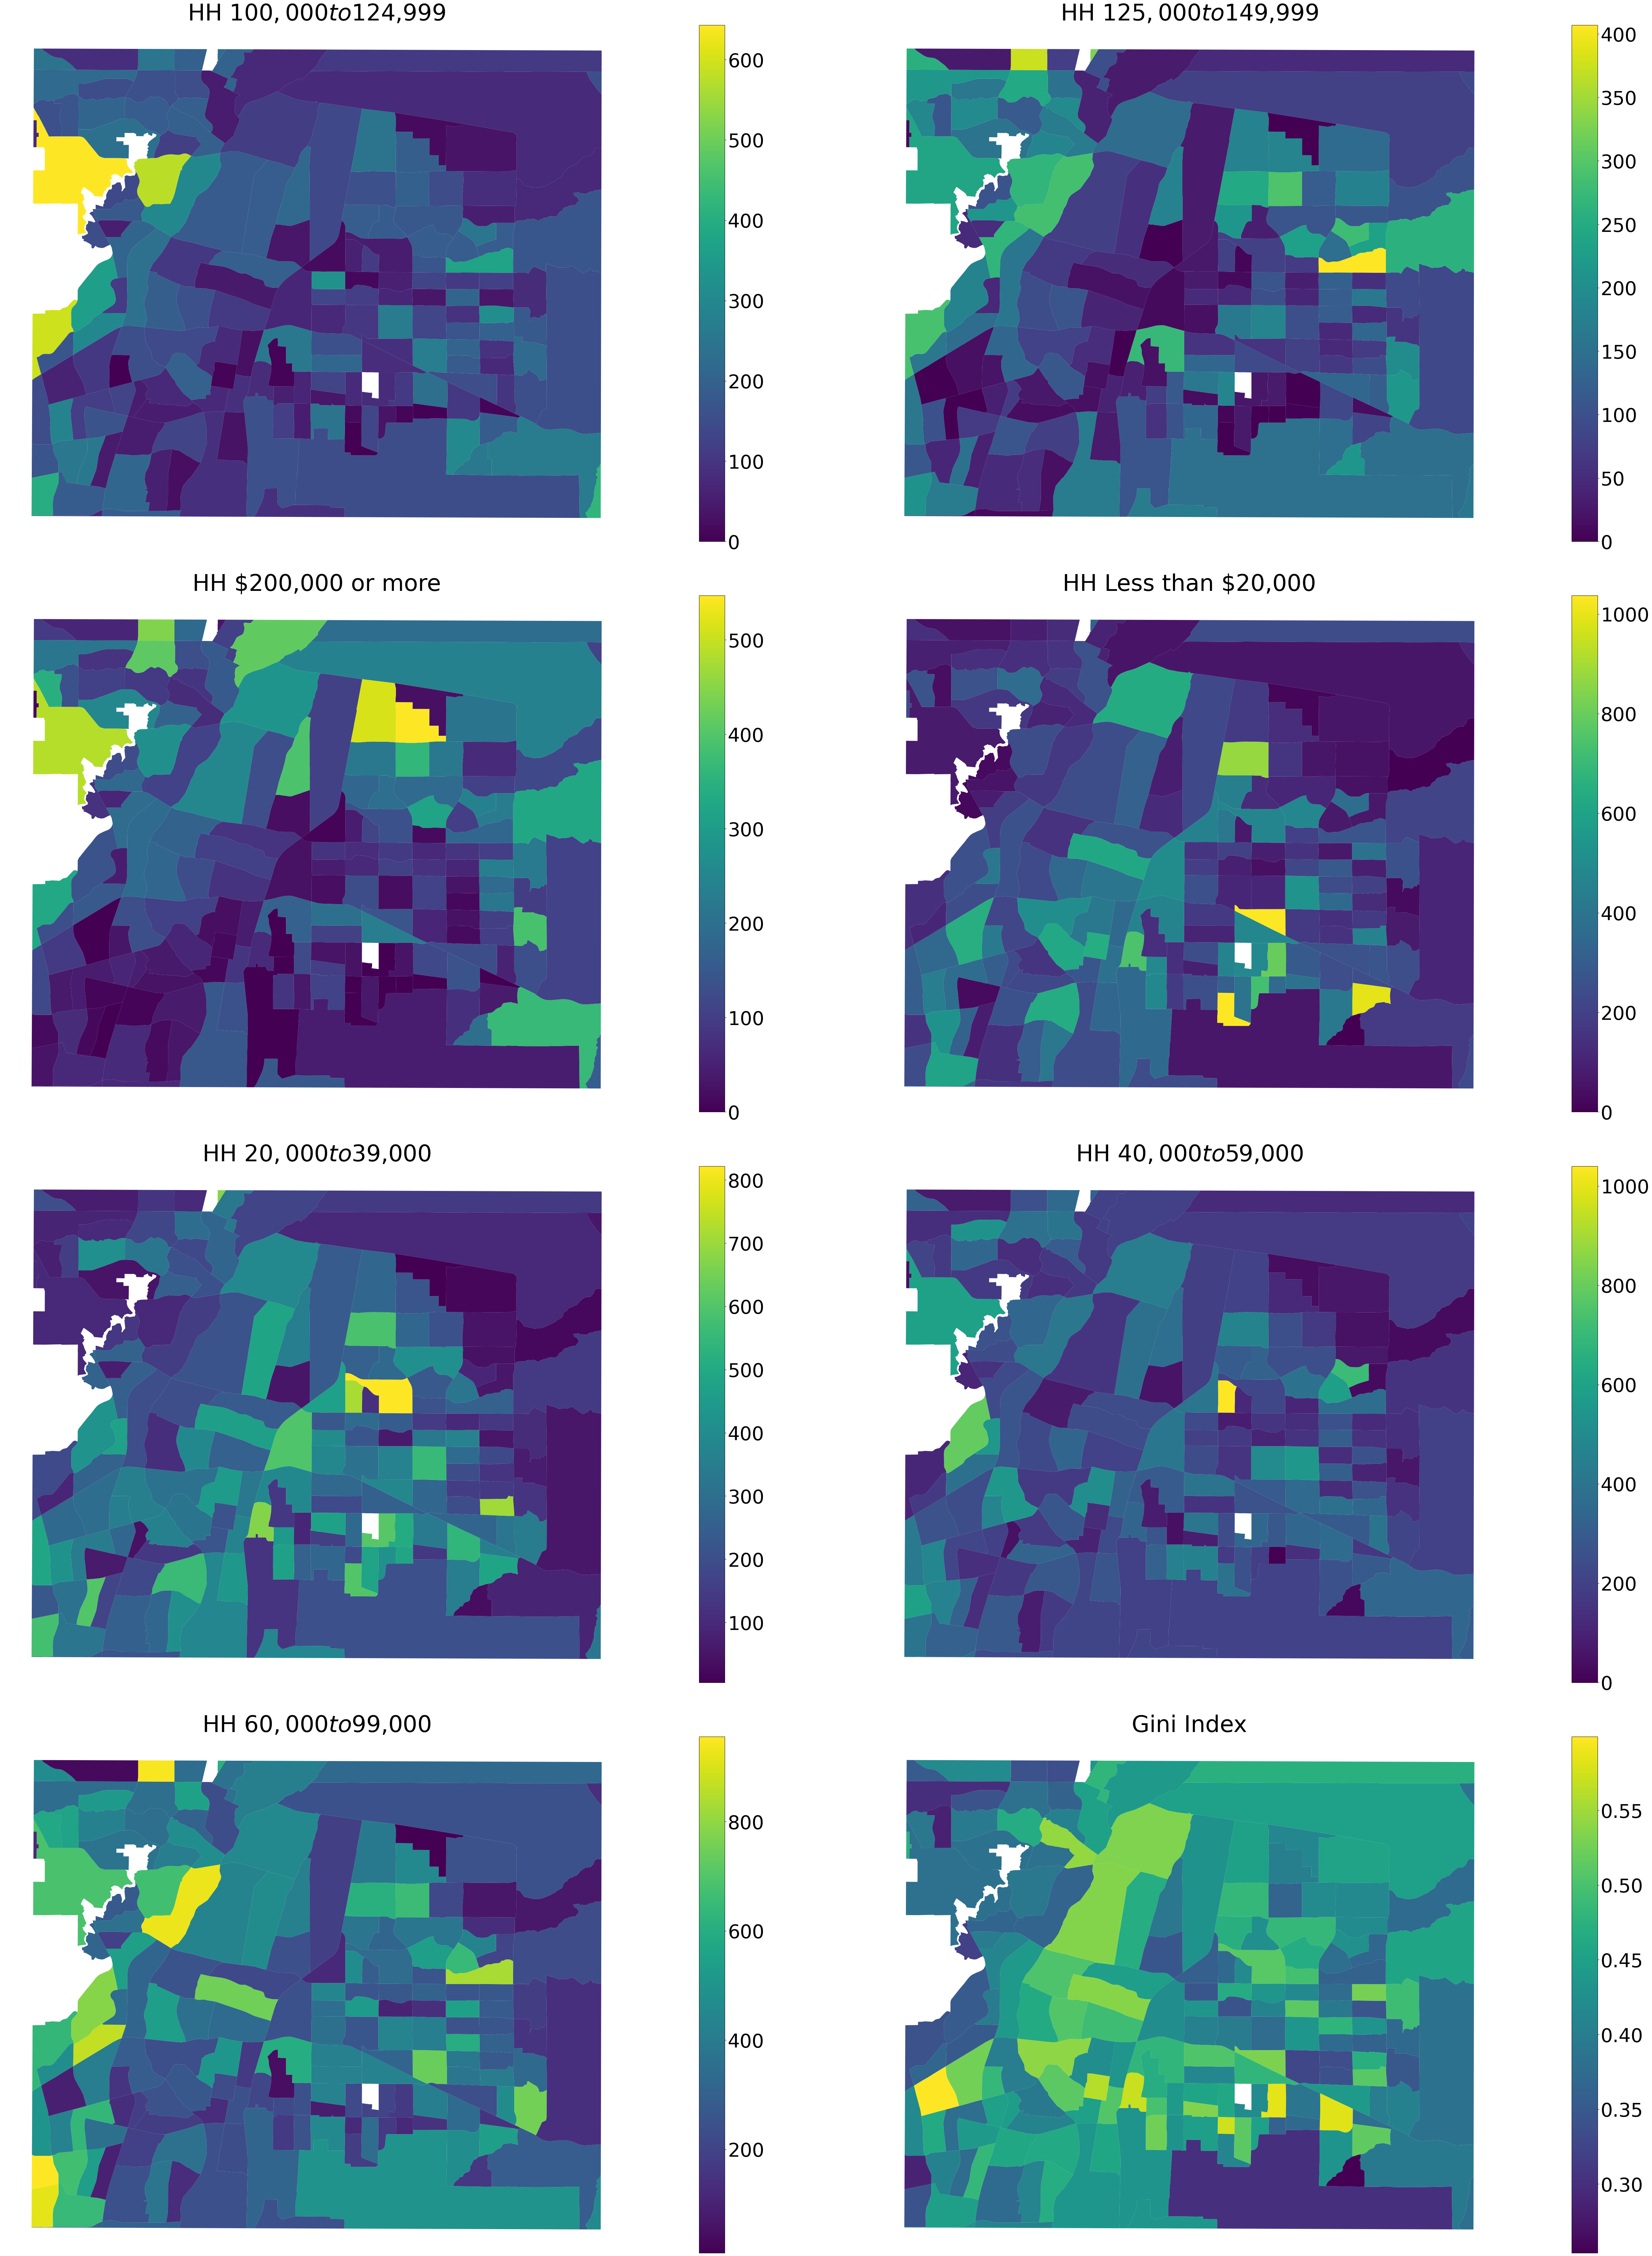

In [202]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(75,75), layout='tight')

axes = axes.flatten()

# Setting the font size
plt.rcParams['font.size'] = '45'
plt.style.use('seaborn-v0_8-dark-palette')

# Plotting each of the extracted variables in a subplot
for ind, col in enumerate(HHCols[:-1]+['Gini Index']):
    ax = axes[ind]
    abq_2022.plot(column=col,
                  ax = ax
                  #, scheme = "quantiles"
                  , linewidth=0, cmap="viridis", 
                    legend=True
                  #, legend_kwds={'loc': 'center left','bbox_to_anchor':(1,0.5),'fmt': "{:.0f}"}
                 ) 
    ax.set_axis_off()
    ax.set_title(col)
plt.subplots_adjust(wspace=None, hspace=None)
plt.show()

## Get Country-wide data

In [203]:
us_demo_2022_dl = c.acs5.state_county(
    fields = list(fields.keys()),
    state_fips = "*",
    county_fips = "*",
    year = 2022
    )
us_demo_2019_dl = c.acs5.state_county(
    fields = list(fields.keys()),
    state_fips = "*",
    county_fips = "*",
    year = 2019
    )
us_demo_2016_dl = c.acs5.state_county(
    fields = list(fields.keys()),
    state_fips = "*",
    county_fips = "*",
    year = 2016
    )

In [204]:
us_demo_2022_df = pd.DataFrame(us_demo_2022_dl)
us_demo_2019_df = pd.DataFrame(us_demo_2019_dl)
us_demo_2016_df = pd.DataFrame(us_demo_2016_dl)

In [205]:
for df in [us_demo_2022_df, us_demo_2019_df, us_demo_2016_df]: 
    df.rename(columns=fields, inplace=True)

In [206]:
us_tract_2022 = gpd.read_file('../../../data/local/tl_2022_us_county.zip')[['GEOID', 'geometry']]
us_tract_2019 = gpd.read_file('../../../data/local/tl_2019_us_county.zip')[['GEOID', 'geometry']]
us_tract_2016 = gpd.read_file('../../../data/local/tl_2016_us_county.zip')[['GEOID', 'geometry']]

In [207]:
for df in [us_demo_2022_df, us_demo_2019_df, us_demo_2016_df]: 
    df['GEOID'] = (df.state + df.county)

In [208]:
us_demo_2022 = us_tract_2022.merge(us_demo_2022_df, on='GEOID')
us_demo_2019 = us_tract_2019.merge(us_demo_2019_df, on='GEOID')
us_demo_2016 = us_tract_2016.merge(us_demo_2016_df, on='GEOID')

In [210]:
us_demo_2022.to_file('../../../data/Census/us_inc_2022.gpkg')
us_demo_2019.to_file('../../../data/Census/us_inc_2019.gpkg')
us_demo_2016.to_file('../../../data/Census/us_inc_sex_2016.gpkg')